### Osteoporosis classification on a matched case-control study

#### In this notebook, there are 3 parts:
- Part 1: data visualization and univeriate feature selection using Chi-square test
- Part 2: data cleaning (converting variables into one-hot encoding)
- Part 3: running ML using LR, RF, SVM, XGB

### Brief data description:

- This is a <b>matched case-control</b> dataset, matching on confounding variables (age, gender, race)
- Total sample size: 61,022 rows, 46 columns
- <b>Numeric variables</b>: 
    - BMI_Avg (BMI already imputed using multiple imputation in SAS) 
    - Age
    - Calcium and Sodium variables ('Calcium_Closest_Osteo', 'Calcium_Avg_Prior', 'Calcium_Avg_Ever', 'Sodium_Closest_Osteo', 'Sodium_Avg_Prior', 'Sodium_Avg_Ever', 'Sodium_Worst_Prior', 'Sodium_Worst_Ever')
- <b>Categorical variables</b>: Gender, Ethnicity, Alcohol_Prior, Tobacco_Prior, etc. (anything with 'prior' in variable names)

### Data preprocessing for numeric variables

For the numeric variables, I converted them into categorical variables. The main purpose of this convertion is to help `Logistic Regression` learn easier in the next step, or to help `Random Forest` split faster with binary variables when building decision trees. 

<br> 
To do this convertion, I created new variables: by `discretize` and create `presence/absence` variables
<br>

- step 1: `discretize`, converting these continuous variables into categorical variables by discretizing them. 
    - Here I applied `qcut` function in Python. Comparing to `decile` (which creates 10 bins), `qcut` creates bins with equally number of data (equal N) in each bin. However, the trade off will be bin interval not equal. All the variables with 'decile' in variable names are the products of this step
    
- step 2: creating `presence/absence` variables to these numeric variables. All the variables with 'cat' in variable names are the products of this step


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
pwd

'/Users/thanhng/ThanhNguyen93.github.io/projects'

In [3]:
cd /Users/thanhng/osteo_project

/Users/thanhng/osteo_project


In [4]:
data = pd.read_csv('osteo_clean.csv')
print(data.shape)
data.head()

(61022, 46)


,Strata,sex,race_combine,Age_combine,osteo_predict,BMI_Avg_imputed,Alcohol_Prior,Tobacco_Prior,Drug_antipsych_prior,Drug_Estrogens_prior,...,Sodium_Worst_Prior_decile,Sodium_Worst_Ever_decile,Calcium_Closest_Osteo_cat,Calcium_Avg_Prior_cat,Calcium_Avg_Ever_cat,Sodium_Closest_Osteo_cat,Sodium_Avg_Prior_cat,Sodium_Avg_Ever_cat,Sodium_Worst_Prior_cat,Sodium_Worst_Ever_cat
0,9576,F,black,from_50_to_70,0.0,37.834028,0,0,0,0,...,NaN,5.0,0,0,1,0,0,1,0,1
1,13833,F,white,from_70_to_80,0.0,32.948625,0,0,0,0,...,NaN,9.0,0,0,1,0,0,1,0,1
2,28858,F,black,from_30_to_50,0.0,33.388021,0,0,0,0,...,NaN,4.0,0,0,1,0,0,1,0,1
3,16496,F,others,from_50_to_70,0.0,28.308928,1,0,0,0,...,9.0,9.0,1,1,1,1,1,1,1,1
4,1,F,white,more_than_80,1.0,22.666667,0,0,1,0,...,4.0,2.0,1,1,1,1,1,1,1,1


In [5]:
data.isna().sum()

Strata                              0
sex                                 0
race_combine                        0
Age_combine                         0
osteo_predict                       0
BMI_Avg_imputed                     0
Alcohol_Prior                       0
Tobacco_Prior                       0
Drug_antipsych_prior                0
Drug_Estrogens_prior                0
Drug_Glucocorticoids_prior          0
Drug_Nsaids_prior                   0
Drug_Opiates_prior                  0
Drug_Thiazide_prior                 0
Drug_Loop_Diuretic_Prior            0
Drug_Pp_inhibitors_prior            0
Drug_Progesterone_prior             0
Drug_Seizure_prior                  0
Drug_Ssris_prior                    0
Drug_Tc_antidepress_prior           0
HeartDisease_Prior                  0
Liver_Prior                         0
PulmDisease_Prior                   0
CNS_Disease_Prior                   0
Malignancy_Prior                    0
Hyponatremia_Prior                  0
Chronic_Hypo

In [6]:
data.dtypes

Strata                            int64
sex                              object
race_combine                     object
Age_combine                      object
osteo_predict                   float64
BMI_Avg_imputed                 float64
Alcohol_Prior                     int64
Tobacco_Prior                     int64
Drug_antipsych_prior              int64
Drug_Estrogens_prior              int64
Drug_Glucocorticoids_prior        int64
Drug_Nsaids_prior                 int64
Drug_Opiates_prior                int64
Drug_Thiazide_prior               int64
Drug_Loop_Diuretic_Prior          int64
Drug_Pp_inhibitors_prior          int64
Drug_Progesterone_prior           int64
Drug_Seizure_prior                int64
Drug_Ssris_prior                  int64
Drug_Tc_antidepress_prior         int64
HeartDisease_Prior                int64
Liver_Prior                       int64
PulmDisease_Prior                 int64
CNS_Disease_Prior                 int64
Malignancy_Prior                  int64


### Part 1: data visualization

This dataset is used for a `case-control study`, matching on demographic variables such as `age`, `sex`, and `gender`. It means that the `case` (having osteo) and `control` (not having osteo) samples  will have similar distributions across confounding variables. In this case, 'osteo' and 'no_osteo' will have equal sample size N across the 3 demographic variables. 

In [7]:
#create a copy of Y for the sake of visualization
data['osteo_label'] = data['osteo_predict'].replace({1.0: 'osteo', 0.0: 'no_osteo'})
data['osteo_label'].value_counts()

no_osteo    30511
osteo       30511
Name: osteo_label, dtype: int64

the data is distributed equally between 2 classes of Y label (`no_osteo` and `osteo`). This is expected because our data is matched based on age variable

Text(0.5, 0.98, 'BMI across Ages groups')

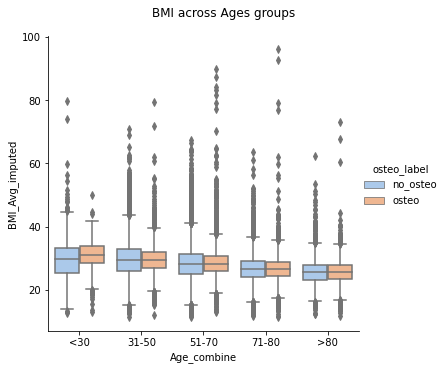

In [127]:
col_order = ['less_than_30', 'from_30_to_50','from_50_to_70', 'from_70_to_80', 'more_than_80']
ax = sns.catplot(y="BMI_Avg_imputed", x="Age_combine", hue='osteo_label', data=data, kind='box', order=col_order, 
                palette="pastel")
ax.set_xticklabels(['<30', '31-50', '51-70', '71-80', '>80'])
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('BMI across Ages groups')

In general, the BMI mean across all the age groups are around 30, suggesting that these patients are obese. But the means of these BMI across all different groups are closely near each other, suggesting that there are not much different in these `age groups`. Looking closely at individual groups, `BMI_Avg_imputed` in group `70_80` has many 'outliers' than in other groups, since their BMI are above 80. 

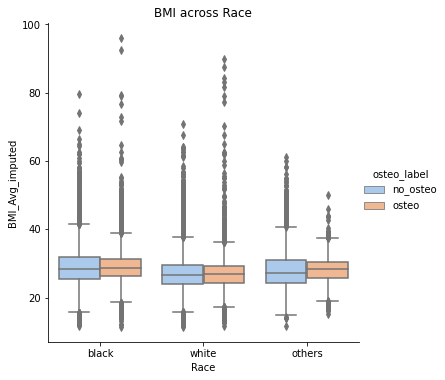

In [126]:
sns.catplot(y="BMI_Avg_imputed", x="race_combine", hue='osteo_label', data=data, kind='box', palette="pastel").set(title='BMI across Race', xlabel='Race')

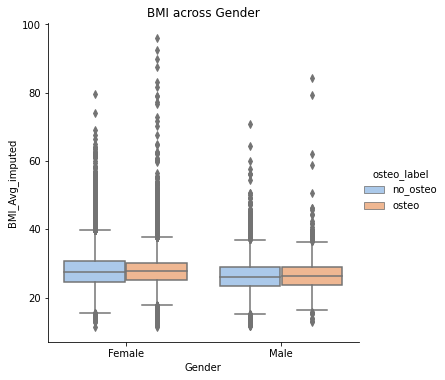

In [125]:
sns.catplot(y="BMI_Avg_imputed", x="sex", hue='osteo_label', data=data, kind='box',palette="pastel" ).set(title='BMI across Gender', xlabel='Gender').set_xticklabels(['Female', 'Male'])

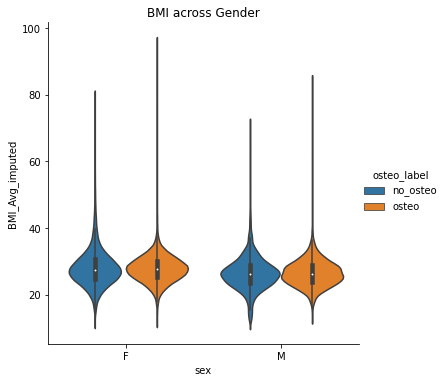

In [11]:
sns.catplot(y="BMI_Avg_imputed", x="sex", hue='osteo_label', data=data, kind='violin').set(title='BMI across Gender')

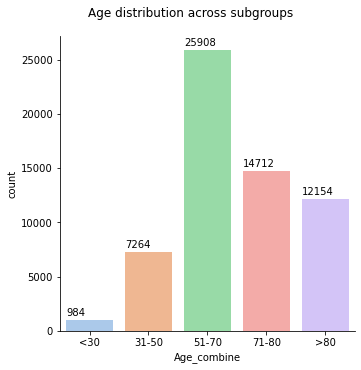

In [89]:
col_order = ['less_than_30', 'from_30_to_50','from_50_to_70', 'from_70_to_80', 'more_than_80']
ax = sns.catplot(x="Age_combine", kind="count", palette="pastel", data=data, order=col_order)
ax.set_xticklabels(['<30', '31-50', '51-70', '71-80', '>80'], ha="center")
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Age distribution across subgroups')

spots = zip(ax.ax.patches)
for spot in spots:
    ax.ax.text(spot[0].get_x(), spot[0].get_height()+400, spot[0].get_height())

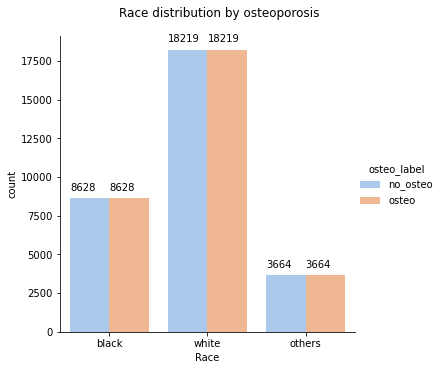

In [103]:
ax = sns.catplot(x="race_combine", kind="count", data=data, hue='osteo_label', 
                palette="pastel").set(xlabel='Race')
ax.set_xticklabels(ha="center")
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Race distribution by osteoporosis')

spots = zip(ax.ax.patches)
for spot in spots:
    ax.ax.text(spot[0].get_x(), spot[0].get_height()+500, spot[0].get_height())

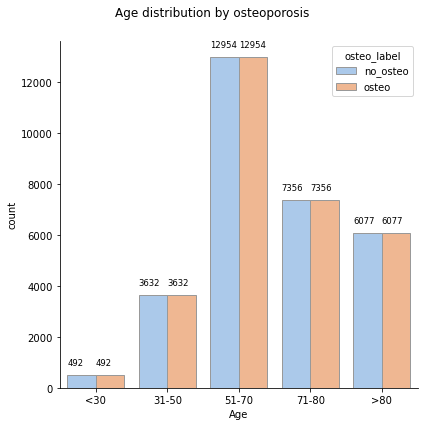

In [107]:
col_order = ['less_than_30', 'from_30_to_50','from_50_to_70', 'from_70_to_80', 'more_than_80']
ax = sns.catplot(x="Age_combine", kind="count", hue="osteo_label",
            palette="pastel", edgecolor=".6",data=data, order=col_order, legend_out=False, height=6).set(xlabel='Age')    
ax.set_xticklabels(['<30', '31-50', '51-70', '71-80', '>80'], ha="center")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Age distribution by osteoporosis')

spots = zip(ax.ax.patches)
for spot in spots:
    ax.ax.text(spot[0].get_x(), spot[0].get_height()+400, spot[0].get_height(), fontsize=8.5)



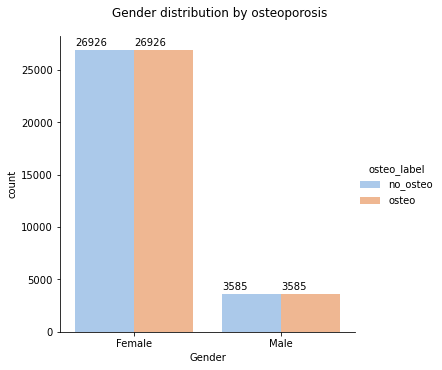

In [106]:
ax = sns.catplot(x="sex", kind="count", data=data, hue='osteo_label', 
                palette="pastel").set(xlabel='Gender')
ax.set_xticklabels(['Female', 'Male'], ha="center")
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Gender distribution by osteoporosis')

spots = zip(ax.ax.patches)
for spot in spots:
    ax.ax.text(spot[0].get_x(), spot[0].get_height()+400, spot[0].get_height())

### Perform `univariate feature selection` using `Chi-square` test since all these variables are categorical variables

To do this, we need to convert categorical variables with `string` into `number representatives` 

In [14]:
data['sex_category'] = data['sex'].copy()
data['sex_category'] = data['sex_category'].replace({'F':1, 'M':0})
data['sex_category'].value_counts()

1    53852
0     7170
Name: sex_category, dtype: int64

In [15]:
#convert race
data['race_combine'].value_counts()

white     36438
black     17256
others     7328
Name: race_combine, dtype: int64

In [16]:
data['race_category'] = data['race_combine'].copy()
data['race_category'] = data['race_category'].replace({'white': '0', 'black':'1', 'others':'2'})
data['race_category'].value_counts()

0    36438
1    17256
2     7328
Name: race_category, dtype: int64

In [17]:
#convert age
data['Age_combine'].value_counts().sort_index()

from_30_to_50     7264
from_50_to_70    25908
from_70_to_80    14712
less_than_30       984
more_than_80     12154
Name: Age_combine, dtype: int64

In [18]:
data['age_category'] = data['Age_combine'].copy()
data['age_category']= data['age_category'].replace({
    'less_than_30': '0',
    'from_30_to_50':'1',
    'from_50_to_70': '2', 
    'from_70_to_80': '3',
    'more_than_80': '4'  
})
data['age_category'].value_counts().sort_index()

0      984
1     7264
2    25908
3    14712
4    12154
Name: age_category, dtype: int64

In [19]:
#fill missing with 0 in multiple cols
lst_col = ['Calcium_Closest_Osteo_decile','Calcium_Avg_Prior_decile', 
        'Sodium_Avg_Prior_decile', 'Sodium_Worst_Prior_decile', 'Sodium_Worst_Ever_decile']
data[lst_col] = data[lst_col].fillna(0).astype(str)

In [20]:
data.isna().sum()

Strata                          0
sex                             0
race_combine                    0
Age_combine                     0
osteo_predict                   0
BMI_Avg_imputed                 0
Alcohol_Prior                   0
Tobacco_Prior                   0
Drug_antipsych_prior            0
Drug_Estrogens_prior            0
Drug_Glucocorticoids_prior      0
Drug_Nsaids_prior               0
Drug_Opiates_prior              0
Drug_Thiazide_prior             0
Drug_Loop_Diuretic_Prior        0
Drug_Pp_inhibitors_prior        0
Drug_Progesterone_prior         0
Drug_Seizure_prior              0
Drug_Ssris_prior                0
Drug_Tc_antidepress_prior       0
HeartDisease_Prior              0
Liver_Prior                     0
PulmDisease_Prior               0
CNS_Disease_Prior               0
Malignancy_Prior                0
Hyponatremia_Prior              0
Chronic_Hyponatremia            0
Recent_Hyponatremia             0
Median_Recent_Hypo_Cat_edit     0
Lowest_Recent_

In [21]:
df_features_cat = data.drop(['Strata', 'sex', 'race_combine',
                             'Age_combine', 'osteo_predict','BMI_Avg_imputed', 'osteo_label'], axis=1)

In [22]:
df_features_cat

,Alcohol_Prior,Tobacco_Prior,Drug_antipsych_prior,Drug_Estrogens_prior,Drug_Glucocorticoids_prior,Drug_Nsaids_prior,Drug_Opiates_prior,Drug_Thiazide_prior,Drug_Loop_Diuretic_Prior,Drug_Pp_inhibitors_prior,...,Calcium_Avg_Prior_cat,Calcium_Avg_Ever_cat,Sodium_Closest_Osteo_cat,Sodium_Avg_Prior_cat,Sodium_Avg_Ever_cat,Sodium_Worst_Prior_cat,Sodium_Worst_Ever_cat,sex_category,race_category,age_category
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,1,2
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,1,1
3,1,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,1,2,2
4,0,0,1,0,0,0,1,0,1,0,...,1,1,1,1,1,1,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61017,0,1,0,0,0,0,1,0,0,1,...,1,1,1,1,1,1,1,1,0,1
61018,0,1,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,0,2
61019,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,3
61020,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,2,2


In [23]:
#perform Chi-square test
from sklearn.feature_selection import SelectKBest, chi2
feature_selection = SelectKBest(chi2, k=5)
feature_selection.fit(df_features_cat, data['osteo_predict'])
selected_features = df_features_cat.columns[feature_selection.get_support()]
print("The five selected features are: ", list(selected_features))

The five selected features are:  ['Chronic_Hyponatremia', 'Recent_Hyponatremia', 'Median_Recent_Hypo_Cat_edit', 'Lowest_Recent_Hypo_Cat_edit', 'Calcium_Avg_Ever_decile']


In [24]:
correlation_score_df = pd.DataFrame(zip(feature_selection.scores_, feature_selection.pvalues_), index=df_features_cat.columns).reset_index()
correlation_score_df.columns=['variables', 'chi2_score', 'chi2_pvalue']
correlation_score_df

,variables,chi2_score,chi2_pvalue
0,Alcohol_Prior,35.041667,3.227251e-09
1,Tobacco_Prior,236.966851,1.803369e-53
2,Drug_antipsych_prior,76.379679,2.340473e-18
3,Drug_Estrogens_prior,19.043103,1.277988e-05
4,Drug_Glucocorticoids_prior,233.095174,1.259957e-52
5,Drug_Nsaids_prior,91.570916,1.076638e-21
6,Drug_Opiates_prior,395.455300,5.373691e-88
7,Drug_Thiazide_prior,88.356643,5.465574e-21
8,Drug_Loop_Diuretic_Prior,60.984050,5.753911e-15
9,Drug_Pp_inhibitors_prior,269.300643,1.611877e-60


Because this `sample size` is large, the `Chi-square test` is likely to 
return a low p-value even for a table with small differences from the expected proportions.


In [25]:
X = pd.DataFrame(feature_selection.transform(df_features_cat),
                 columns=selected_features)
X.head()

,Chronic_Hyponatremia,Recent_Hyponatremia,Median_Recent_Hypo_Cat_edit,Lowest_Recent_Hypo_Cat_edit,Calcium_Avg_Ever_decile
0,0,0,0.0,0.0,9
1,0,0,0.0,0.0,5
2,0,0,0.0,0.0,0
3,0,0,0.0,0.0,9
4,0,0,0.0,0.0,5


### Check `correlation` to see what variables are correlated to each other

<AxesSubplot:>

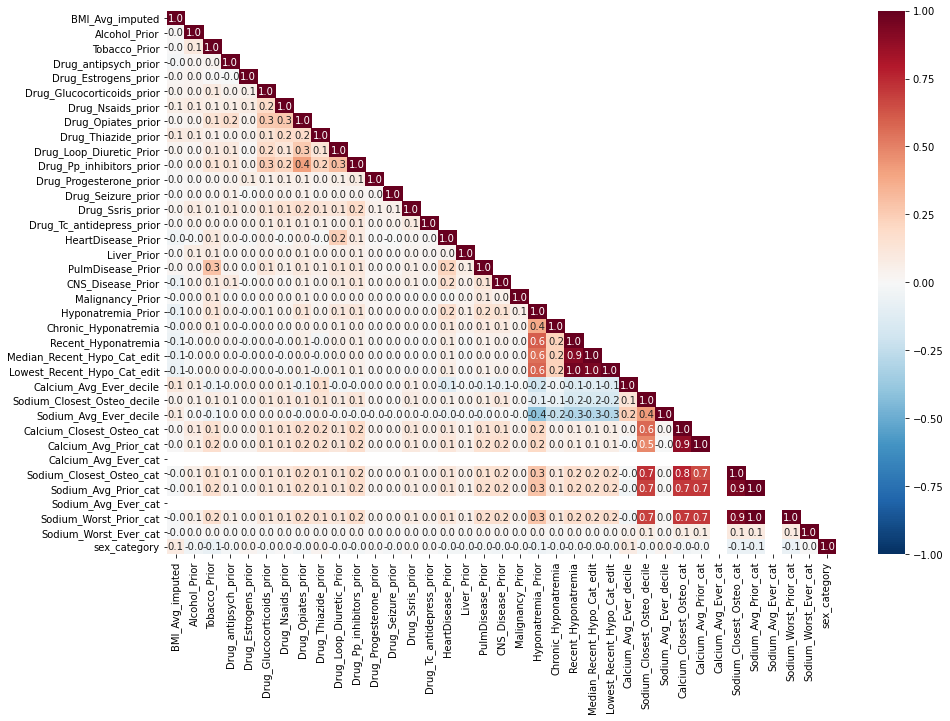

In [26]:
# Create correlation matrix
#remove 'strata' and Y
data_corr = data.drop(['Strata', 'osteo_predict'], axis=1)
corr_mat = data_corr.corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat, annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1,
            mask=mask)

<AxesSubplot:>

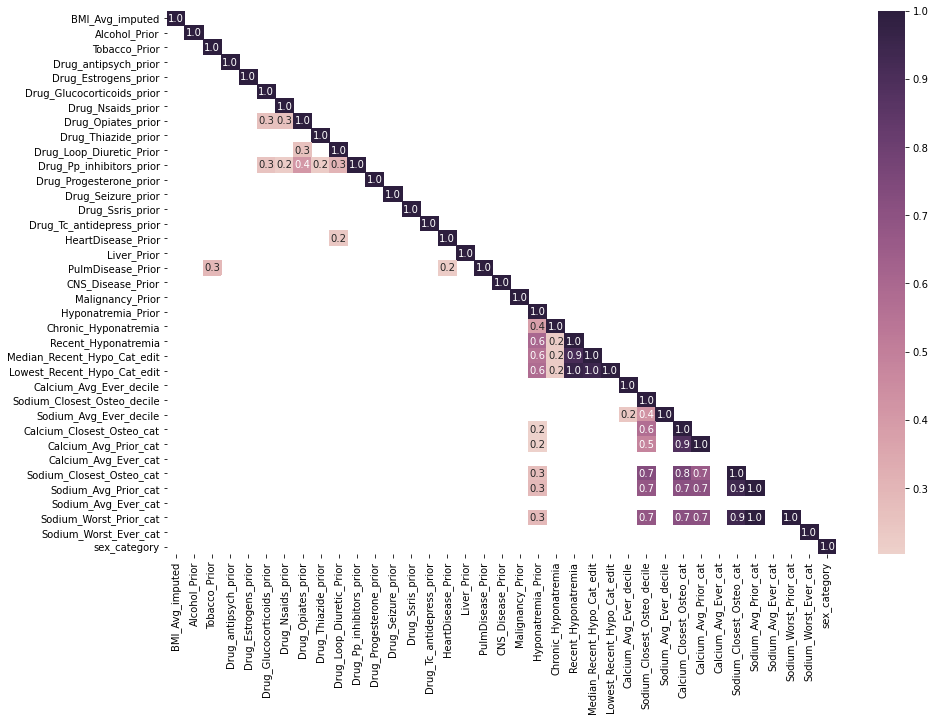

In [27]:
#check for correlation score that larger than 0.2
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat[corr_mat > 0.2], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200), mask=mask)

<AxesSubplot:>

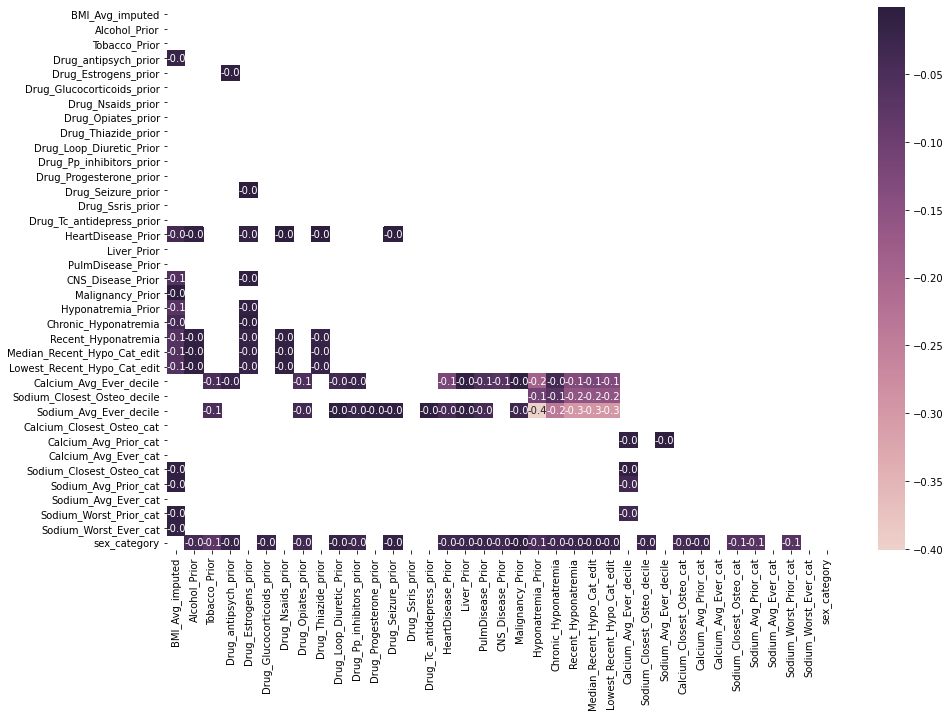

In [28]:
#check for correlation score that are negative
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat[corr_mat < 0.0], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200), mask=mask)

### Part 2: One-hot encoding (OHE)

- dummy: dtype = uint8, when input to ML, can't decode
Thus, we use OHE sklearn

In [29]:
from sklearn.preprocessing import OneHotEncoder
def CONVERT_TO_OHE(original_data):
    non_ohe = original_data.drop(['sex','race_combine', 'Age_combine',
                                  'Strata','BMI_Avg_imputed', 'osteo_predict'], axis=1)
    #convert non_ohe to string
    non_ohe = non_ohe.astype(str)
    enc = OneHotEncoder(drop='first')
    enc_fit = enc.fit_transform(non_ohe)
    col_names = enc.get_feature_names(non_ohe.columns)
    ohe_df = pd.DataFrame(enc_fit.toarray(), columns=col_names)
    #combine with original data
    combine = original_data[['Strata','BMI_Avg_imputed', 'osteo_predict']]
    data_ohe = pd.concat([ohe_df, combine], axis=1) 
    return data_ohe

### Part 3: training models using `LR`, `RF`, `SVM`, `Adaboost`, `XGB`

We choose these models because majority of our variables are category. And since some of them are slightly correlated to each other, we don't use `Naive Bayes` here because `NB` assumption may be violated. 

The `confusion matrix` follows this order: 

|negative class| positive class|
| ------------- |-------------|
| TN| FP| 
| FN | TP |

In [30]:
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
import sklearn.linear_model as linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve

from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

#########
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

In [31]:
def TRAIN_MODEL_ML(data_ohe, classifier, tune):
    X = data_ohe.drop(['osteo_predict'], axis=1)
    Y = data_ohe.filter(['Strata', 'osteo_predict'])

    fold = KFold(10, shuffle = True, random_state = 12345)
    strata = data_ohe['Strata'].unique()

    all_preds = np.full(data.shape[0], 100)
    probability = np.ones(data.shape[0])

    training_acc = []
    testing_acc = []

    for train_index, test_index in fold.split(strata):

        train_index_strata = strata[train_index]
        test_index_strata = strata[test_index]

        X_train = X.loc[X['Strata'].isin(train_index_strata)]
        X_train = X_train.drop(['Strata'], axis = 1)

        X_test = X.loc[X['Strata'].isin(test_index_strata)]
        X_test = X_test.drop(['Strata'], axis = 1)

        y_train = Y.loc[Y['Strata'].isin(train_index_strata)]['osteo_predict']
        y_test = Y.loc[Y['Strata'].isin(test_index_strata)]['osteo_predict']


        if classifier == 'LR':
            lr = LogisticRegression(solver='liblinear')
            
        if classifier == 'RF':
            # Create a based model
            lr = RandomForestClassifier(random_state = 12345)
            if tune == 'true':
                param_grid = {
                    'bootstrap': [True],
                    'max_depth': [80, 90, 100, 110],
                    'max_features': [2, 3],
                    'min_samples_leaf': [3, 4, 5],
                    'min_samples_split': [8, 10, 12],
                    'n_estimators': [100, 200, 300, 1000]
                            }
                # Instantiate the grid search model
                grid_search = GridSearchCV(estimator = lr, param_grid = param_grid,
                                          cv = 3, n_jobs = -1, verbose = 1)
                # Fit the grid search to the data
                grid_search.fit(X_train, y_train)
                print(grid_search.best_params_)

                best_grid = grid_search.best_estimator_
                grid_accuracy = evaluate(best_grid, X_test, y_test)
                print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

        if classifier == 'SVM_linear':
           svm_linear = LinearSVC(max_iter = 1000, random_state = 12345, C = 0.001, loss='hinge')
           lr = CalibratedClassifierCV(svm_linear)

        if classifier == 'SVM_rbf':
            lr = svm.SVC(kernel='rbf', probability = True, max_iter = 1000, C= 100, gamma = 30)

        if classifier == 'AdaBoost':
            logistic_regression = linear_model.LogisticRegression(random_state = 12345, solver = 'lbfgs')
            lr = AdaBoostClassifier(n_estimators=100,
                                    base_estimator = logistic_regression,
                                    learning_rate=1)

        if classifier == 'XGB':
            lr =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                             max_depth=3, random_state=42)

        fit = lr.fit(X_train, y_train)

        y_pred = lr.predict(X_test)
        all_preds[y_test.index] = y_pred

        probs = lr.predict_proba(X_test)
        probability[y_test.index] = probs[:, 1]

        training_acc.append(fit.score(X_train, y_train))
        testing_acc.append(fit.score(X_test, y_test))

    data['all_pred'] = all_preds
    data['probability'] = probability
    print('\nfinal result of %s model: ' % classifier)
    print(classification_report(data['osteo_predict'], data['all_pred']), '\n')
    print(confusion_matrix(data['osteo_predict'], data['all_pred']), '\n')

    print('ROC_AUC of', classifier, '', roc_auc_score(data['osteo_predict'], data['probability']))
    return data, training_acc, testing_acc, lr

In [32]:
def RUN_MULTIPLE_MODELS(data, classifiers, tune):
    result = []
    for classifier in classifiers:
        data_ohe = CONVERT_TO_OHE(data)
        data_ohe['osteo_predict'] = data_ohe['osteo_predict'].astype(str).replace({'0.0': '0', '1.0': '1'})
        model_data, train_acc, test_acc, clf = TRAIN_MODEL_ML(data_ohe, classifier, tune)
        fpr,tpr,threshold=roc_curve(model_data['osteo_predict'], model_data['probability'])
        auc = roc_auc_score(model_data['osteo_predict'], model_data['probability'])
        result.append({'classifier': classifier,
                          'FPR': fpr,
                          'TPR': tpr,
                          'AUC': auc,
                          'training_acc': train_acc,
                          'testing_acc': test_acc, 
                          'clf': clf})

    result_df = pd.DataFrame(result, columns=['classifier','FPR','TPR','AUC',
                                      'training_acc', 'testing_acc', 'clf'])

    result_df.set_index('classifier', inplace=True)
    return result_df

In [33]:
def PLOT_MULTIPLE_ROC(result_df):
    #plot multiple AUC in 1 plot
    fig = plt.figure(figsize=(8,6))
    for i in result_df.index:
        plt.plot(result_df.loc[i]['FPR'],
                 result_df.loc[i]['TPR'],
                 label="{}, AUC={:.3f}".format(i, result_df.loc[i]['AUC']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.title('ROC Curve Comparison', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')
    plt.show()

In [34]:
data_train_model = data.drop(['sex_category', 'race_category', 'age_category', 'osteo_label'], 
                            axis=1)

In [35]:
classifiers = ['LR', 'RF']
lr_res = RUN_MULTIPLE_MODELS(data_train_model, classifiers, 'false')


final result of LR model: 
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74     30511
         1.0       0.75      0.68      0.71     30511

    accuracy                           0.72     61022
   macro avg       0.73      0.72      0.72     61022
weighted avg       0.73      0.72      0.72     61022
 

[[23474  7037]
 [ 9799 20712]] 

ROC_AUC of LR  0.8088236758353666

final result of RF model: 
              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72     30511
         1.0       0.73      0.68      0.70     30511

    accuracy                           0.71     61022
   macro avg       0.72      0.71      0.71     61022
weighted avg       0.72      0.71      0.71     61022
 

[[22843  7668]
 [ 9744 20767]] 

ROC_AUC of RF  0.7939774953285219


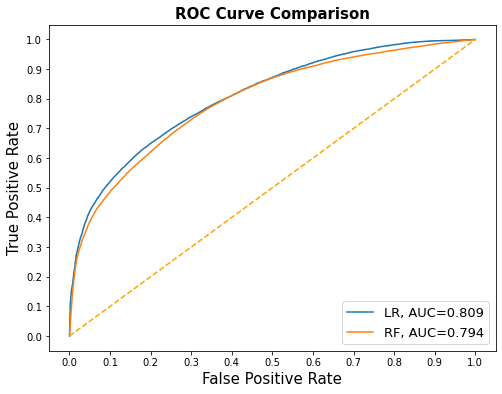

In [36]:
PLOT_MULTIPLE_ROC(lr_res)

- `LR` performs better than `RF` with its higher `AUC`. This also suggests that our data is biased toward linear model `LR` rathan than non-linear model `RF`
- according to the `confusion matrix` of these 2 models, our variables are biased towards negative class since the `TN` and `FN` are higher than the `TP` and `FP`. 

In [37]:
lr_res

,FPR,TPR,AUC,training_acc,testing_acc,clf
classifier,,,,,,
LR,"[0.0, 0.0, 0.0, 3.2775064730752846e-05, 3.2775...","[0.0, 3.2775064730752846e-05, 0.00147487791288...",0.808824,"[0.7262099857970065, 0.7268936635105608, 0.726...","[0.7187090432503277, 0.724188790560472, 0.7273...",LogisticRegression(solver='liblinear')
RF,"[0.0, 0.004391858673920881, 0.0069155386581888...","[0.0, 0.0905575038510701, 0.1370653207040084, ...",0.793977,"[0.999981791033905, 0.9999635833940277, 0.9999...","[0.7123197903014417, 0.7055063913470994, 0.724...","(DecisionTreeClassifier(max_features='auto', r..."


In [38]:
classifiers = ['SVM_linear', 'SVM_rbf']
svm = RUN_MULTIPLE_MODELS(data_train_model, classifiers, 'false')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration


final result of SVM_linear model: 
              precision    recall  f1-score   support

         0.0       0.65      0.76      0.70     30511
         1.0       0.72      0.59      0.65     30511

    accuracy                           0.68     61022
   macro avg       0.68      0.68      0.68     61022
weighted avg       0.68      0.68      0.68     61022
 

[[23339  7172]
 [12399 18112]] 

ROC_AUC of SVM_linear  0.7416086534360626


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-pa


final result of SVM_rbf model: 
              precision    recall  f1-score   support

         0.0       0.50      0.99      0.67     30511
         1.0       0.57      0.01      0.02     30511

    accuracy                           0.50     61022
   macro avg       0.54      0.50      0.34     61022
weighted avg       0.54      0.50      0.34     61022
 

[[30249   262]
 [30157   354]] 

ROC_AUC of SVM_rbf  0.5081350872046656


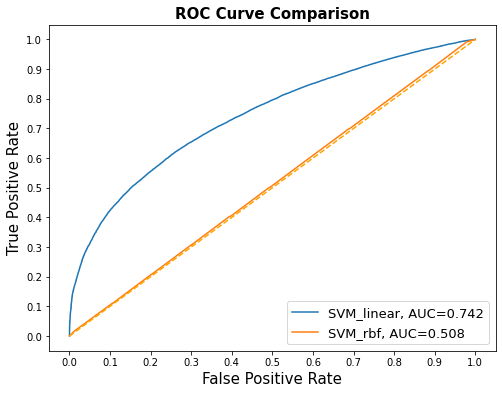

In [39]:
PLOT_MULTIPLE_ROC(svm)

In [40]:
classifiers = ['AdaBoost', 'XGB']
boosted_models = RUN_MULTIPLE_MODELS(data_train_model, classifiers, 'false')


final result of AdaBoost model: 
              precision    recall  f1-score   support

         0.0       0.66      0.78      0.71     30511
         1.0       0.73      0.59      0.65     30511

    accuracy                           0.68     61022
   macro avg       0.69      0.68      0.68     61022
weighted avg       0.69      0.68      0.68     61022
 

[[23700  6811]
 [12443 18068]] 

ROC_AUC of AdaBoost  0.7515335781064527

final result of XGB model: 
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75     30511
         1.0       0.76      0.71      0.74     30511

    accuracy                           0.74     61022
   macro avg       0.74      0.74      0.74     61022
weighted avg       0.74      0.74      0.74     61022
 

[[23628  6883]
 [ 8782 21729]] 

ROC_AUC of XGB  0.8326386710050808


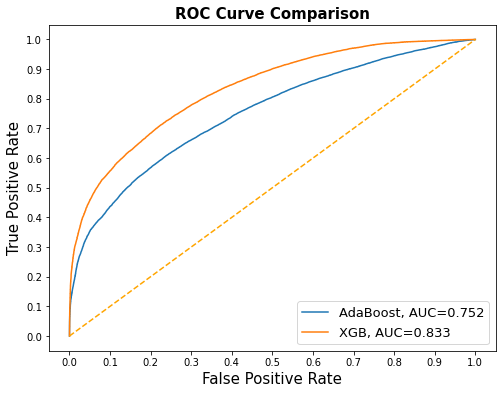

In [41]:
PLOT_MULTIPLE_ROC(boosted_models)

In [42]:
def PLOT_ACCURACY(training_acc, testing_acc):
    plt.plot(training_acc)
    plt.plot(testing_acc)
    plt.xlabel('10-fold CV')
    plt.ylabel('accuracy')
    plt.legend(['training_acc', 'testing_acc'])
    plt.title('Model accuracy')
    plt.show()

In [43]:
res_df = pd.concat([lr_res, svm, boosted_models]).reset_index()
res_df

,classifier,FPR,TPR,AUC,training_acc,testing_acc,clf
0,LR,"[0.0, 0.0, 0.0, 3.2775064730752846e-05, 3.2775...","[0.0, 3.2775064730752846e-05, 0.00147487791288...",0.808824,"[0.7262099857970065, 0.7268936635105608, 0.726...","[0.7187090432503277, 0.724188790560472, 0.7273...",LogisticRegression(solver='liblinear')
1,RF,"[0.0, 0.004391858673920881, 0.0069155386581888...","[0.0, 0.0905575038510701, 0.1370653207040084, ...",0.793977,"[0.999981791033905, 0.9999635833940277, 0.9999...","[0.7123197903014417, 0.7055063913470994, 0.724...","(DecisionTreeClassifier(max_features='auto', r..."
2,SVM_linear,"[0.0, 0.0, 0.0, 3.2775064730752846e-05, 3.2775...","[0.0, 3.2775064730752846e-05, 0.01025859526072...",0.741609,"[0.6813977202374449, 0.6805899490167516, 0.678...","[0.67021625163827, 0.678302196001311, 0.686004...",CalibratedClassifierCV(base_estimator=LinearSV...
3,SVM_rbf,"[0.0, 0.0, 3.2775064730752846e-05, 3.277506473...","[0.0, 3.2775064730752846e-05, 3.27750647307528...",0.508135,"[0.5147856804690629, 0.5142388929351784, 0.514...","[0.5018020969855832, 0.4995083579154376, 0.504...","SVC(C=100, gamma=30, max_iter=1000, probabilit..."
4,AdaBoost,"[0.0, 0.0, 0.0, 3.2775064730752846e-05, 3.2775...","[0.0, 3.2775064730752846e-05, 0.01265117498607...",0.751534,"[0.6866965293710623, 0.6859796067006555, 0.685...","[0.6805373525557011, 0.6856768272697477, 0.695...","(LogisticRegression(random_state=1176181795), ..."
5,XGB,"[0.0, 0.0, 0.0, 3.2775064730752846e-05, 3.2775...","[0.0, 3.2775064730752846e-05, 0.00016387532365...",0.832639,"[0.7685640409337557, 0.7699563000728332, 0.768...","[0.7385321100917431, 0.7340216322517208, 0.747...",([DecisionTreeRegressor(criterion='friedman_ms...


classifier:  LR


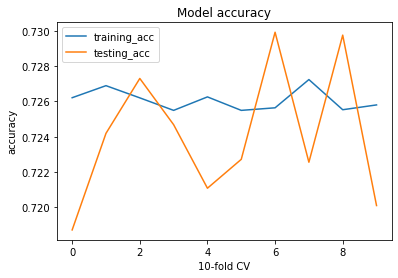



classifier:  RF


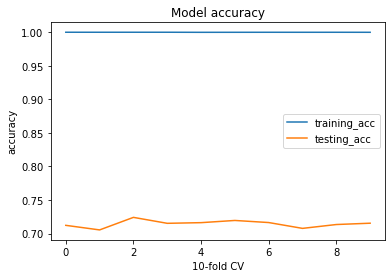



classifier:  SVM_linear


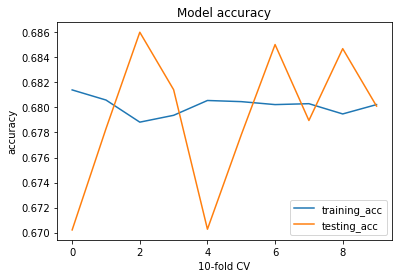



classifier:  SVM_rbf


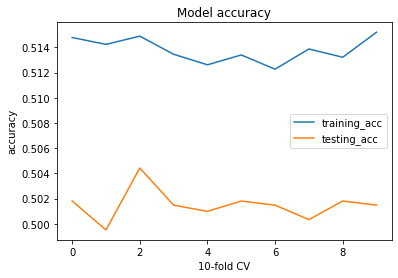



classifier:  AdaBoost


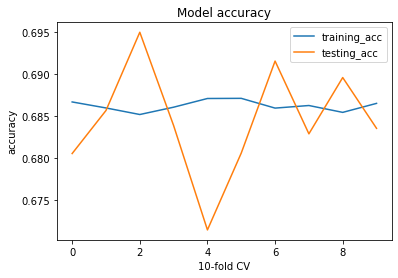



classifier:  XGB


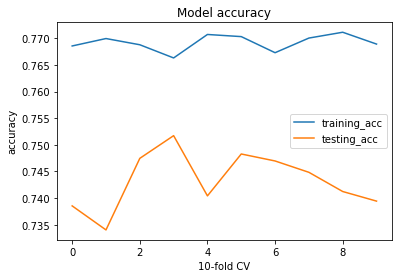

In [44]:
for i in range(res_df.shape[0]):
    classifier = res_df['classifier'][i]
    training = res_df['training_acc'][i]
    testing = res_df['testing_acc'][i]
    print('classifier: ', classifier)
    PLOT_ACCURACY(training, testing)
    print('\n')

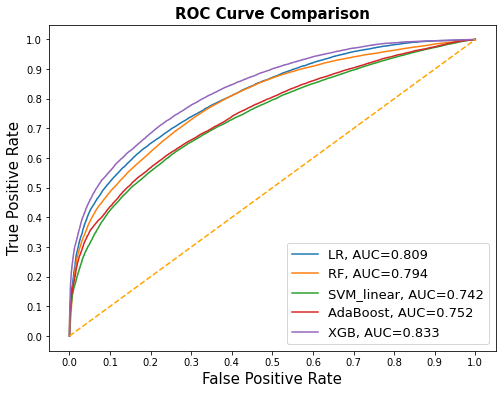

In [124]:
PLOT_MULTIPLE_ROC(pd.concat([lr_res, svm[:-1], boosted_models]))

### Conclusion
- The `AUC plot` above shows that `XGB` performs best with this data with highest AUC score. 
- `SVM_linear` has higher AUC score than `SVM_rbf`, and `LR` has higher AUC score than `RF` suggests that this dataset favors `linear model` than `non-linear model`
- the `confusion matrix` of all 6 models indicates a consistent trend that the variables tend to predict more negative class than positive class, despite our data is `case-control` study. 

- Next steps will be `feature selection` and `parameter tunining` for these models